### ME455: Introduction to the ergodic metric

Date: May 09, 2024

Author: Muchen Sun

References:

[1] *Mathew, G. and Mezić, I.*, 2011. **Metrics for ergodicity and design of ergodic dynamics for multi-agent systems**. Physica D: Nonlinear Phenomena, 240(4-5), pp.432-442. [[**Link**](https://www.sciencedirect.com/science/article/pii/S016727891000285X)]

In [7]:
import numpy as np
np.set_printoptions(precision=4)

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.linewidth'] = 3
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['axes.titlepad'] = 8.0
mpl.rcParams['xtick.major.size'] = 6
mpl.rcParams['xtick.major.width'] = 3
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.major.size'] = 6
mpl.rcParams['ytick.major.width'] = 3
mpl.rcParams['ytick.labelsize'] = 20
mpl.rcParams['lines.markersize'] = 5
mpl.rcParams['legend.fontsize'] = 15

#### Fourier basis function

We start with defining of the exploration space $\mathcal{X}$, which is a $d$-dimensional rectangular Euclidean space. Without loss of generality, we define the search space as:

$$\mathcal{X}=[0,L_1]\times\cdots\times[0,L_d], $$  

where $L_i$ is the boundary length of the $i$-th dimension. The *normalized* Fourier basis function is defined over the search space. Denote a state within the search space as $x = [x_1, \dots, x_d] \in \mathcal{X}$, the normalized Fourier basis function is characterized by a $d$-dimensional *index vector* $k = [k_1, \dots, k_d]$, where each entry of the vector is a whole number $k_i \in [0, 1, 2, \dots, K]$:

$$
\begin{align}
f_k(x) & = \frac{1}{h_k} \prod_{i=1}^{d} \cos\left( \frac{k_i \pi}{L_i} x_i \right),
\end{align}
$$

where $h_k$ is the normalization term, such that the function space norm of each basis function $\left[\int_{\mathcal{X}} f_k(x)^2 dx\right]^{\frac{1}{2}}$ is $1$.

The normalized basis functions consist of a set of *orthonormal bases* in the infinite dimensional function space. Thus, we can transform any function with the same domain (the search space) into a set of new coordinates under these *orthonormal bases*.

Given a spatial probability density function $p(x)$, we can transform this function as follow:

$$
\begin{align}
    p(x) & = \sum_{k}^{\infty} \left( \underbrace{\int_{\mathcal{X}} p(x) f_k(x) dx}_{\phi_k} \right) \cdot f_k(x) \\
        & = \sum_{k}^{\infty} \phi_k \cdot f_k(x)
\end{align}
$$ where all the coefficients $[c_k]$ consist the coordinate of the function $p(x)$ under the bases $[f_k(x)]$.

Though the equality only holds in theory when we have an infinite number of basis functions, in practice, we can choose a finite number of basis functions to approximate an infinite dimensional function $p(x)$ within a finite dimensional Euclidean space (a finite number of coefficients).

This transformation from an infinite dimensional function space to a finite dimensional vector space is crucial for the ergodic metric. We now verify this transformation below.

In [8]:
### We define a Gaussian mixture model as the spatial probability density function
from scipy.stats import multivariate_normal as mvn

mean1 = np.array([0.35, 0.38])
cov1 = np.array([
    [0.01, 0.004],
    [0.004, 0.01]
])
w1 = 0.5

mean2 = np.array([0.68, 0.25])
cov2 = np.array([
    [0.005, -0.003],
    [-0.003, 0.005]
])
w2 = 0.2

mean3 = np.array([0.56, 0.64])
cov3 = np.array([
    [0.008, 0.0],
    [0.0, 0.004]
])
w3 = 0.3


# Define the Gaussian-mixture density function here
def pdf(x):
    return w1 * mvn.pdf(x, mean1, cov1) + \
           w2 * mvn.pdf(x, mean2, cov2) + \
           w3 * mvn.pdf(x, mean3, cov3)

In [9]:
### We are going to use 10 coefficients per dimension --- so 100 index vectors in total

num_k_per_dim = 10
ks_dim1, ks_dim2 = np.meshgrid(
    np.arange(num_k_per_dim), np.arange(num_k_per_dim)
)
ks = np.array([ks_dim1.ravel(), ks_dim2.ravel()]).T  # this is the set of all index vectors
print('First 5 index vectors: ')
print(ks[:5, :])

# define a 1-by-1 2D search space
L_list = np.array([1.0, 1.0])  # boundaries for each dimension

# Discretize the search space into 100-by-100 mesh grids
grids_x, grids_y = np.meshgrid(
    np.linspace(0, L_list[0], 100),
    np.linspace(0, L_list[1], 100)
)
grids = np.array([grids_x.ravel(), grids_y.ravel()]).T
dx = 1.0 / 99
dy = 1.0 / 99  # the resolution of the grids

# Compute the coefficients
coefficients = np.zeros(ks.shape[0])  # number of coefficients matches the number of index vectors
for i, k_vec in enumerate(ks):
    # step 1: evaluate the fourier basis function over all the grid cells
    fk_vals = np.prod(np.cos(np.pi * k_vec / L_list * grids), axis=1)  # we use NumPy's broadcasting feature to simplify computation
    hk = np.sqrt(np.sum(np.square(fk_vals)) * dx * dy)  # normalization term
    fk_vals /= hk

    # step 2: evaluate the spatial probabilty density function over all the grid cells
    pdf_vals = pdf(grids)  # this can computed ahead of the time

    # step 3: approximate the integral through the Riemann sum for the coefficient
    phik = np.sum(fk_vals * pdf_vals) * dx * dy
    coefficients[i] = phik

print('First 5 coefficients: ', coefficients[:5])

First 5 index vectors: 
[[0 0]
 [1 0]
 [2 0]
 [3 0]
 [4 0]]
First 5 coefficients:  [ 0.9898  0.0799 -0.7756 -0.063  -0.0555]


In [10]:
print(coefficients.shape)

(100,)


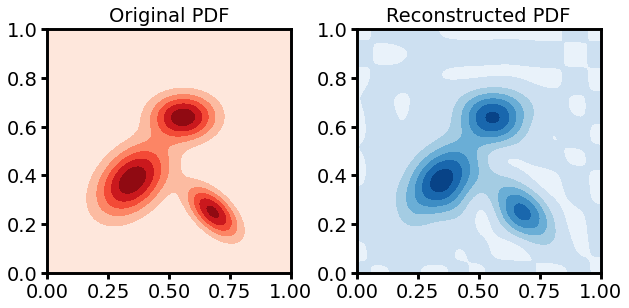

In [11]:
### We can verify the correctness of the coefficients by reconstructing the probability
### density function through the coefficients

pdf_recon = np.zeros(grids.shape[0])
for i, (phik, k_vec) in enumerate(zip(coefficients, ks)):
    fk_vals = np.prod(np.cos(np.pi * k_vec / L_list * grids), axis=1)
    hk = np.sqrt(np.sum(np.square(fk_vals)) * dx * dy)
    fk_vals /= hk

    pdf_recon += phik * fk_vals

pdf_gt = pdf(grids)  # ground truth density function

# visualize for comparison
fig, axes = plt.subplots(1, 2, figsize=(9,5), dpi=70, tight_layout=True)

ax = axes[0]
ax.set_aspect('equal')
ax.set_xlim(0.0, L_list[0])
ax.set_ylim(0.0, L_list[1])
ax.set_title('Original PDF')
ax.contourf(grids_x, grids_y, pdf_gt.reshape(grids_x.shape), cmap='Reds')

ax = axes[1]
ax.set_aspect('equal')
ax.set_xlim(0.0, L_list[0])
ax.set_ylim(0.0, L_list[1])
ax.set_title('Reconstructed PDF')
ax.contourf(grids_x, grids_y, pdf_recon.reshape(grids_x.shape), cmap='Blues')

plt.show()
plt.close()

#### Ergodic metric: distance measure between a trajectory and a distribution

The intuition behind the ergodic metric is that we want to measure the difference between a spatial probability density function and the **empirical distribution** of a trajectory $s(t)$ within the search space. The empirical distribution is defined as:

$$
\begin{align}
\Phi_{s(t)}(x) = \frac{1}{T} \int_{0}^{T} \delta(x {-} s(t)) dt,
\end{align}
$$

where $\delta(\cdot)$ is a Dirac delta function.

The key insight here is that we can also transform the empirical distribution into a vector space through the Fourier basis functions. In fact, the Dirac delta function further simplifies the calculation:

$$
\begin{align}
    \Phi_{s(t)}(x) & = \sum_{k}^{\infty} \left[ \int_{\mathcal{X}} \left( \frac{1}{T} \int_{0}^{T} \delta(x {-} s(t)) dt \right) f_k(x) dx \right] \cdot f_k(x) \\
    & = \sum_{k}^{\infty} \left(\underbrace{\frac{1}{T} \int_{0}^{T} f_k(s(t)) dt}_{c_k} \right) \cdot f_k(x) \\
        & = \sum_{k}^{\infty} c_k \cdot f_k(x)
\end{align}
$$

This allows us to approximate the distance between a probability density function $p(x)$ and a trajectory's empirical distribution $\Phi_{s(t)}(x)$ in a finite dimensional vector space with the following formula, which is the mathematical formula of the ergodic metric:
\begin{align}
    \mathcal{E}(p(x), s(t)) & = \sum_{k} \lambda_k \cdot (c_k - \phi_k)^2, \\
    \lambda_k & = (1 + \Vert k \Vert)^{-\frac{d+1}{2}}.
\end{align}

This ergodic metric formula is equivalent to a distance metric given by the Sobolev space norm of negative index $-\frac{d+1}{2}$. [1]

**If the ergodic metric between a dynamic system's trajectory, over an infinitely long time horizon, and a spatial probability density function is zero, the system is ergodic with respect to the spatial probability distribution.**

#### Ergodic control: connecting temporal statistics with spatial statistics

The goal of ergodic control is to design a dynamic system, through optimal control approaches, that is ergodic with respect to a target spatial probability distribution. In other words, to design a dynamic system with smallest possible ergodic metric value with respect a target spatial probability density function.

An ergodic system connects the temporal statistic of its behavior with the spatial statistic of the target distribution: an ergodic visits any region of the search space with the amount of time proportional to the integrated value of the spatial distribution over the same region. This property naturally introduces two advantages of using ergodic control as an exploration strategy:

(1) An ergodic system will eventually cover the entire search space, so long as the target spatial distribution is a non-zero probability density over any region of the space. This is the intrinsic coverage guarantee of ergodic control;

(2) An ergodic system automatically allocates the time spent on investigating each region of the search space based on the integrated density of the region. This is preferrable to standard coverage approach as an ergodic system covers a distribution instead of just the search space.

Here we give an example of calculating the ergodic metric given a trajectory. We will use the Gaussian-mixture distribution defined above as the target spatial distribution.

Assuming we have a dynamic system, where the state of the system at each time step is a sample from the Guassian-mixture distribution. Such a system is indeed ergodic, thus should lead to small value when we evaluate the ergodic metric.

In [12]:
# define the dynamics
def dyn(st):
    mixture_category = np.where(np.random.multinomial(1, [w1, w2, w3])==1.0)[0][0]
    if mixture_category == 0:
        st_new = mvn.rvs(mean1, cov1)
    elif mixture_category == 1:
        st_new = mvn.rvs(mean2, cov2)
    else:
        st_new = mvn.rvs(mean3, cov3)
    return st_new


# simulate the trajectory
dt = 0.1
tsteps = 200
st = np.ones(2) * 0.5
s_traj = []
for t in range(tsteps):
    st_new = dyn(st)
    s_traj.append(st_new)
    st = st_new.copy()
s_traj = np.array(s_traj)

# compute the coefficient of the trajectory
traj_coefficients = np.zeros(ks.shape[0])
for i, k_vec in enumerate(ks):
    # step 1: evaluate the basis function over the trajectory
    fk_vals = np.prod(np.cos(np.pi * k_vec / L_list * s_traj), axis=1)
    hk = np.sqrt(np.sum(np.square(np.prod(np.cos(np.pi * k_vec / L_list * grids), axis=1))) * dx * dy)
    fk_vals /= hk

    # step 2: approximate the integral through the Riemann sum for the coefficient
    ck = np.sum(fk_vals) * dt / (tsteps * dt)
    traj_coefficients[i] = ck

print('First 5 coefficients: ', traj_coefficients[:5])

First 5 coefficients:  [ 0.99    0.069  -0.7548 -0.0629 -0.0807]


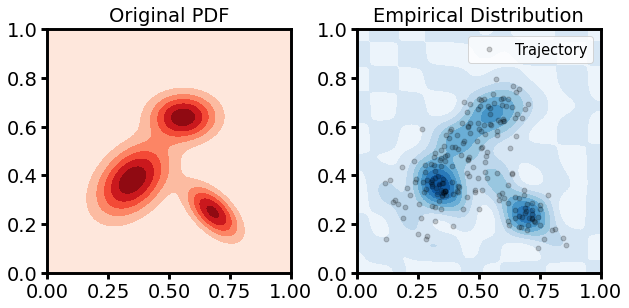

In [13]:
phi_recon = np.zeros(grids.shape[0])
for i, (ck, k_vec) in enumerate(zip(traj_coefficients, ks)):
    fk_vals = np.prod(np.cos(np.pi * k_vec / L_list * grids), axis=1)
    hk = np.sqrt(np.sum(np.square(fk_vals)) * dx * dy)
    fk_vals /= hk

    phi_recon += ck * fk_vals

pdf_gt = pdf(grids)  # ground truth density function

# visualize for comparison
fig, axes = plt.subplots(1, 2, figsize=(9,5), dpi=70, tight_layout=True)

ax = axes[0]
ax.set_aspect('equal')
ax.set_xlim(0.0, L_list[0])
ax.set_ylim(0.0, L_list[1])
ax.set_title('Original PDF')
ax.contourf(grids_x, grids_y, pdf_gt.reshape(grids_x.shape), cmap='Reds')

ax = axes[1]
ax.set_aspect('equal')
ax.set_xlim(0.0, L_list[0])
ax.set_ylim(0.0, L_list[1])
ax.set_title('Empirical Distribution')
ax.contourf(grids_x, grids_y, phi_recon.reshape(grids_x.shape), cmap='Blues')
ax.plot(s_traj[:,0], s_traj[:,1], linestyle='', marker='o', color='k', alpha=0.2, label='Trajectory')
# ax.plot(s_traj[:,0], s_traj[:,1], linestyle='-', color='k', alpha=0.5, label='Trajectory')
ax.legend(loc=1)

plt.show()
plt.close()

In [14]:
# Finally, we compute the erogdic metric
lamk_list = np.power(1.0 + np.linalg.norm(ks, axis=1), -3/2.0)
erg_metric = np.sum(lamk_list * np.square(coefficients - traj_coefficients))
print('ergodic metric: ', erg_metric)

ergodic metric:  0.017637549979853947


In [15]:
phi_list = np.empty(0)
fk_list = np.empty(0)
h_list = np.empty(0)
c_list = np.empty(0)
f_traj = np.empty(0)
lam_list = np.empty(0)
dfkdxdt_list = np.empty(0)

init_u_traj=np.tile(np.array([-0.1, 0.1]), reps=100)

def pdf(x, w, dists, dx, dy):
    r = np.zeros(x.shape[0])
    for i in range(x.shape[0]):
        for j in range(w.shape[0]):
            r[i] += w[j] * dists[j].pdf(x[i])
    
    r/= np.sum(r * dx * dy)
    return r

dt = 0.1
T = 10.0
tlist = np.arange(0, T, dt)

x0 = np.array([0.3, 0.3])
q = 0.01

R_u = np.diag([0.0, 0.0])
Q_x = np.diag([0.01, 0.01])
P1 = np.diag([2.0, 2.0])

Q_z = np.diag([0.01, 0.01])
R_v = np.diag([0.01, 0.01])

weights = np.array([w1, w2, w3])
means = np.array([mean1, mean2, mean3])
covs = np.array([cov1, cov2, cov3])

dist = []
for mu, cov in zip(means, covs):
    dist.append(mvn(mu, cov))

num_k_per_dim = 10
ks_dim1, ks_dim2 = np.meshgrid(
    np.arange(num_k_per_dim), np.arange(num_k_per_dim)
)
ks = np.array([ks_dim1.ravel(), ks_dim2.ravel()]).T  # this is the set of all index vectors
(
    np.linspace(0, L_list[0], 1000),
    np.linspace(0, L_list[1], 1000)
)

grids = np.array([grids_x.ravel(), grids_y.ravel()]).T

N = 1000 + 1
dx = dy = 1/ 1000
grid_pdf = pdf(grids, weights, dist, dx, dy)

phi = np.zeros((ks.shape[0]))
fk = np.zeros(shape = (ks.shape[0], N*N))
h = np.zeros((ks.shape[0]))

for i, k_vec in enumerate(ks):
    fk_vals = np.prod(np.cos(np.pi * k_vec / L_list * grids), axis=1)
    h[i] = np.sqrt(np.sum(np.square(fk_vals)) * dx * dy)
    fk_vals /= h[i]
    fk[i, :] = fk_vals

    phi[i] = np.sum(grid_pdf * fk_vals * dx * dy)
    

c_list = np.zeros(ks.shape[0])
f_traj = np.zeros((ks.shape[0], tsteps))
lam_list = np.power(1.0 + np.linalg.norm(ks, axis=1), -3/2.0)
dfdxdt = np.zeros((ks.shape[0], 2))

def dyn(xt, ut):
    
    return ut

def get_A(xt, ut):
    return np.eye(2)* 0.0

def get_B(xt, ut):
    return np.eye(2)

def step(xt, ut):
    k1 = dt * dyn(xt, ut)
    k2 = dt * dyn(xt + 0.5 * k1, ut)
    k3 = dt * dyn(xt + 0.5 * k2, ut)
    k4 = dt * dyn(xt + k3, ut)
    
    xt_new = xt + (k1 + 2*k2 + 2*k3 + k4) / 6.0
    return xt_new

def traj_sim(x0, ulist):
    tsteps = ulist.shape[0]
    x_traj = np.zeros((tsteps, 2))
    xt = x0.copy()
    for t in range(tsteps):
        xt_new = step(xt, ulist[t])
        x_traj[t] = xt_new
        xt = xt_new.copy()
    
    return x_traj


def dldx(t,xt,ut):
    index = np.where(tlist == t)[0][0]
    dvec = np.zeros(2)
    
    for lam_k, ck, phi_k, hk, k_vec, fk_traj, dfkdxdt in zip(
            lam_list, c_list, phi_list, h_list, ks, f_traj, dfkdxdt_list
        ):
        
        fk = fk_traj[index]
        
        dfdx = -1/hk * np.pi * np.sin(k_vec*np.pi*xt) * \
                np.cos(k_vec[::-1]*np.pi*xt[::-1])
        
        dvec += q * lam_k * 2 * (ck - phi_k) * 1/T * dfdx
        
    return dvec

def dldu(t,xt,ut):
    dvec = np.zeros(2)
    dvec = R_u * ut
    return dvec

def J(x,u):
    J_v = 0.0
    
    J_v += q * np.sum(lam_list * np.square(c_list - phi_list))
    
    for a in u:
        J_v += a.T @ R_u @ a
        
    return J_v

def ilqr_iter(x0, u_traj):
    x_traj = traj_sim(x0, u_traj)
    
    c_l =  np.zeros(ks.shape[0])
    f_t = np.zeros((ks.shape[0], x_traj.shape[0]))
    for i , (k,h) in enumerate(zip(ks, h_list)):
        f_val = np.prod(np.cos(np.pi * k / L_list * x_traj), axis=1)
        dfdxdt = np.zeros(2)
        
        h = h_list[i]
        f_val /= h
        
        ck = np.sum(f_val) * dt / T
        
        for xt in x_traj:
            dfdx = -1/h * np.pi * np.sin(k*np.pi*xt) * np.cos(k[::-1]*np.pi*xt[::-1])
            dfdxdt += dfdx * dt
            
        
        dfkdxdt_list[i, :] = dfdxdt     
        f_t[i, :] = f_val
        c_l[i] = ck
        

    A_list = np.zeros((tsteps, 2, 2))
    B_list = np.zeros((tsteps, 2, 2))    
    a_list = np.zeros((tsteps, 2))
    b_list = np.zeros((tsteps, 2))
    
    for idx,t in enumerate(tlist):    
        A_list[idx] = get_A(x_traj[idx], u_traj[idx])
        B_list[idx] = get_B(x_traj[idx], u_traj[idx])
        a_list[idx] = dldx(t, x_traj[idx], u_traj[idx])
        b_list[idx] = dldu(t, x_traj[idx], u_traj[idx])
        
    xd_T = np.array([2.0 * tlist[-1] / np.pi, 0.0, np.pi / 2.0])
    
    xT = x_traj[-1]
    xT_2 = x_traj[int(x_traj.shape[0]/2), :]
    
    p1 = 2 * P1 * (xT - mean2) * (xT - mean3)
    
    p1 = np.zeros(2)
    
    def zp_dyn(t, zp):
        zt = zp[:2]
        pt = zp[2:]
        
        t_idx = (t/dt).astype(int)
        
        At = A_list[t_idx]
        Bt = B_list[t_idx]
        at = a_list[t_idx]
        bt = b_list[t_idx]
        
        M11 = At
        M12 = np.zeros((2,2))
        M21 = np.zeros((2,2))
        M22 = -At.T
        dyn_mat = np.block([[M11, M12], [M21, M22]])
        
        m1 = -Bt @ np.linalg.inv(R_v.T) @ (pt.T @ Bt + bt.T)
        m2 = -at -zt @ Q_z
        
        dyn_vec = np.hstack([m1, m2])
        
        return dyn_mat @ zp + dyn_vec
    
    def zp_dyn_list(t_list, zp_list):
        list_len = len(t_list)
        zp_dot_list = np.zeros((4, list_len))
        for _i in range(list_len):
            zp_dot_list[:, _i] = zp_dyn(t_list[_i], zp_list[:, _i])
        return zp_dot_list
    
    def zp_bc(zp0, zpT):
        z0 = zp0[:2]
        p0 = zp0[2:]

        zT = zpT[:2]
        pT = zpT[2:]

        bc = np.zeros(4)
        bc[:2] = z0
        bc[2:] = np.abs(pT - p1)        
    
    res = solve_bvp(zp_dyn_list, zp_bc, tlist, np.zeros((4, tlist.shape[0])), verbose =1, max_nodes = 100)

    zp_t = res.sol(tlist)

    z_t = zp_t[:2, :]
    p_t = zp_t[2:, :]                
    
    u_traj_new = np.zeros((tsteps, 2))

    for _i in range(tsteps):
        At = A_list[_i]
        Bt = B_list[_i]
        at = a_list[_i]
        bt = b_list[_i]

        zt = z_t[_i]
        pt = p_t[_i]

        u_traj_new[_i, :] = -np.linalg.inv(R_v.T) @ (pt.T @ Bt + bt.T)

    return u_traj_new, c_list

u_traj = init_u_traj.copy()
J_list = np.array(J(traj_sim(x0, u_traj),u_traj))

for iter in range(100):
    x_traj = traj_sim(x0, u_traj)

    v_traj , clist = ilqr_iter(x0, u_traj)

    gamma = 0.001
    alpha = 1e-4
    beta = 0.5

    while J(x_traj,u_traj + gamma*v_traj) > J(x_traj,u_traj) + alpha * gamma * np.abs(np.trace(v_traj.T @ v_traj)):
        # print(gamma)
        gamma *= beta
    # update control for the next iteration
    u_traj += gamma * v_traj
    J_list[iter+1] = J(traj_sim(x0, u_traj),u_traj)

init_x_traj = traj_sim(x0, init_u_traj)

fig, ax = plt.subplots(1,3, figsize=(15,4))

ax[0].plot(init_x_traj[:,0], init_x_traj[:,1], linestyle='-', color='C0', label='Initial')
ax[0].plot(x_traj[:,0], x_traj[:,1], linestyle='-', color='C1', label='Final')
# ax[0].plot(x_d_traj[:,0], x_d_traj[:,1], linestyle='-', color='C2', label='Desired')
ax[0].imshow(grid_pdf.reshape(grids_x.shape), extent=(0,1,0,1), origin='lower', cmap='Reds', alpha=0.5)
ax[0].legend(loc='upper right')
ax[1].plot(np.arange(0,2*np.pi,dt), u_traj[:,0], linestyle='-', color='C0', label='u1')
ax[1].plot(np.arange(0,2*np.pi,dt), u_traj[:,1], linestyle='-', color='C1', label='u2')
ax[1].legend(loc = 'upper right')
ax[2].plot(J_list, linestyle='-', color='C0')
plt.show()
plt.close()

        



ValueError: could not broadcast input array from shape (10000,) into shape (1002001,)

#### (Bonus) Accelerated computation of ergodic metric

You may have noticed that most of the operations for computing the ergodic metric, mainly the calculation of the coefficients, can be done in parallel. In general, we need to evalulate **each** fourier basis function (with each index vector) over **each** state that we are interested in --- here the states can the discretized state space or the states within a trajectory.

Here we show can example of leveraging this structure to accelerate the computation of coefficients. By using NumPy's broadcasting feature, we can compute the coefficients without a single for loop!

Below is how we were computing the coefficients:

```python
coefficients = np.zeros(ks.shape[0])  
for i, k_vec in enumerate(ks):
    fk_vals = np.prod(np.cos(np.pi * k_vec / L_list * grids), axis=1)
    hk = np.sqrt(np.sum(np.square(fk_vals)) * dx * dy)
    fk_vals /= hk

    pdf_vals = pdf(grids)  
    
    phik = np.sum(fk_vals * pdf_vals) * dx * dy
    coefficients[i] = phik
```

We were already using broadcasting to avoid the loop over each grid cells in the discretized search space, now we will further optimize to get rid of the loop over index vectors.

In [ ]:
fk_vals_tensor = np.cos(np.pi * ks[:,np.newaxis] / L_list * grids)
print(fk_vals_tensor.shape)

This tensor `fk_vals_tensor` with the shape (100, 10000, 2) contains the evaluation of the fourier basis function at **each** index vector (100 in total), **each** grid cell in the discretized state space (100*100 in total), and **each** dimension of the state (2 in total). Based on this tensor, we can calculate the coefficients as follow:

In [ ]:
# compute the normalization terms for each index vector
hk_list = np.sqrt(np.sum(np.square(np.prod(fk_vals_tensor, axis=2)), axis=1) * dx * dy)

# compute the coefficients
coefficients_new = np.sum(pdf(grids) * np.prod(fk_vals_tensor, axis=2) / hk_list[:,np.newaxis], axis=1) * dx * dy

# verify that this optimized implementation produces the same results
print('difference: ', np.linalg.norm(coefficients - coefficients_new))

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_bvp
from scipy.stats import multivariate_normal as mvn


mean1 = np.array([0.35, 0.38])
cov1 = np.array([
    [0.01, 0.004],
    [0.004, 0.01]
])
w1 = 0.5

mean2 = np.array([0.68, 0.25])
cov2 = np.array([
    [0.005, -0.003],
    [-0.003, 0.005]
])
w2 = 0.2

mean3 = np.array([0.56, 0.64])
cov3 = np.array([
    [0.008, 0.0],
    [0.0, 0.004]
])
w3 = 0.3



phi_list = np.empty(0)
fk_list = np.empty(0)
h_list = np.empty(0)
c_list = np.empty(0)
f_traj = np.empty(0)
lam_list = np.empty(0)
dfkdxdt_list = np.empty(0)

init_u_traj=np.tile(np.array([-0.1, 0.1]), reps=100)

def pdf(x, w, dists, dx, dy):
    r = np.zeros(x.shape[0])
    for i in range(x.shape[0]):
        for j in range(w.shape[0]):
            r[i] += w[j] * dists[j].pdf(x[i])
    
    r/= np.sum(r * dx * dy)
    return r

dt = 0.1
T = 10.0
tlist = np.arange(0, T, dt)
tsteps = tlist.shape[0]

x0 = np.array([0.3, 0.3])
q = 0.01

R_u = np.diag([0.0, 0.0])
Q_x = np.diag([0.01, 0.01])
P1 = np.diag([2.0, 2.0])

Q_z = np.diag([0.01, 0.01])
R_v = np.diag([0.01, 0.01])

weights = np.array([w1, w2, w3])
means = np.array([mean1, mean2, mean3])
covs = np.array([cov1, cov2, cov3])

dist = []
for mu, cov in zip(means, covs):
    dist.append(mvn(mu, cov))

num_k_per_dim = 10
ks_dim1, ks_dim2 = np.meshgrid(
    np.arange(num_k_per_dim), np.arange(num_k_per_dim)
)
ks = np.array([ks_dim1.ravel(), ks_dim2.ravel()]).T  # this is the set of all index vectors

L_list = np.array([1.0, 1.0])
grids_x, grids_y = np.meshgrid(
                                np.linspace(0, L_list[0], 1001),
                                np.linspace(0, L_list[1], 1001)
                            )

grids = np.array([grids_x.ravel(), grids_y.ravel()]).T

N = 1000 + 1
dx = dy = 1/ 1000
grid_pdf = pdf(grids, weights, dist, dx, dy)

phi_list = np.zeros((ks.shape[0]))
fk_list = np.zeros(shape = (ks.shape[0], N*N))
h_list = np.zeros((ks.shape[0]))

for i, k_vec in enumerate(ks):
    fk_vals = np.prod(np.cos(np.pi * k_vec / L_list * grids), axis=1)
    h_temp = np.sqrt(np.sum(np.square(fk_vals)) * dx * dy)
    fk_vals /= h_temp
    fk_list[i, :] = fk_vals

    phi_list[i] = np.sum(grid_pdf * fk_vals * dx * dy)
    h_list[i] = h_temp

c_list = np.zeros(ks.shape[0])
f_traj = np.zeros((ks.shape[0], tsteps))
lam_list = np.power(1.0 + np.linalg.norm(ks, axis=1), -3/2.0)
dfdxdt = np.zeros((ks.shape[0], 2))

def dyn(xt, ut):
    
    return ut

def get_A(xt, ut):
    return np.eye(2)* 0.0

def get_B(xt, ut):
    return np.eye(2)

def step(xt, ut):
    k1 = dt * dyn(xt, ut)
    k2 = dt * dyn(xt + 0.5 * k1, ut)
    k3 = dt * dyn(xt + 0.5 * k2, ut)
    k4 = dt * dyn(xt + k3, ut)
    
    xt_new = xt + (k1 + 2*k2 + 2*k3 + k4) / 6.0
    return xt_new

def traj_sim(x0, ulist):
    tsteps = ulist.shape[0]
    x_traj = np.zeros((tsteps, 2))
    xt = x0.copy()
    for t in range(tsteps):
        xt_new = step(xt, ulist[t])
        x_traj[t] = xt_new
        xt = xt_new.copy()
    
    return x_traj


def dldx(t,xt,ut):
    index = np.where(tlist == t)[0][0]
    dvec = np.zeros(2)
    
    for lam_k, ck, phi_k, hk, k_vec, fk_traj, dfkdxdt in zip(
            lam_list, c_list, phi_list, h_list, ks, f_traj, dfkdxdt_list
        ):
        
        fk = fk_traj[index]
        
        dfdx = -1/hk * np.pi * np.sin(k_vec*np.pi*xt) * \
                np.cos(k_vec[::-1]*np.pi*xt[::-1])
        
        dvec += q * lam_k * 2 * (ck - phi_k) * 1/T * dfdx
        
    return dvec

def dldu(t,xt,ut):
    dvec = np.zeros(2)
    rlist = np.diag(R_u)
    dvec = rlist * ut
    return dvec

def J(x,u):
    J_v = 0.0
    
    # print(q * np.sum(lam_list * np.square(c_list - phi_list)))
    J_v += q * np.sum(lam_list * np.square(c_list - phi_list))
    
    for a in u:
        # print(a)
        print(R_u)
        # J_v += a.T @ R_u @ a * dt
        J_v += a.T * R_u * a * dt
        
        
    return J_v

def ilqr_iter(x0, u_traj):
    x_traj = traj_sim(x0, u_traj)
    
    c_list =  np.zeros(ks.shape[0])
    f_t = np.zeros((ks.shape[0], x_traj.shape[0]))
    for i , (k,h) in enumerate(zip(ks, h_list)):
        f_val = np.prod(np.cos(np.pi * k / L_list * x_traj), axis=1)
        dfdxdt = np.zeros(2)
        
        h = h_list[i]
        f_val /= h
        
        ck = np.sum(f_val) * dt / T
        
        for xt in x_traj:
            dfdx = -1/h * np.pi * np.sin(k*np.pi*xt) * np.cos(k[::-1]*np.pi*xt[::-1])
            dfdxdt += dfdx * dt
            
        
        dfkdxdt_list[i, :] = dfdxdt     
        f_t[i, :] = f_val
        c_list[i] = ck
        

    A_list = np.zeros((tsteps, 2, 2))
    B_list = np.zeros((tsteps, 2, 2))    
    a_list = np.zeros((tsteps, 2))
    b_list = np.zeros((tsteps, 2))
    
    for idx,t in enumerate(tlist):    
        A_list[idx] = get_A(x_traj[idx], u_traj[idx])
        B_list[idx] = get_B(x_traj[idx], u_traj[idx])
        a_list[idx] = dldx(t, x_traj[idx], u_traj[idx])
        b_list[idx] = dldu(t, x_traj[idx], u_traj[idx])
        
    xd_T = np.array([2.0 * tlist[-1] / np.pi, 0.0, np.pi / 2.0])
    
    xT = x_traj[-1]
    xT_2 = x_traj[int(x_traj.shape[0]/2), :]
    
    p1 = 2 * P1 * (xT - mean2) * (xT_2 - mean3)
    
    p1 = np.zeros(2)
    
    def zp_dyn(t, zp):
        zt = zp[:2]
        pt = zp[2:]
        
        t_idx = (t/dt).astype(int)
        
        At = A_list[t_idx]
        Bt = B_list[t_idx]
        at = a_list[t_idx]
        bt = b_list[t_idx]
        
        M11 = At
        M12 = np.zeros((2,2))
        M21 = np.zeros((2,2))
        M22 = -At.T
        dyn_mat = np.block([[M11, M12], [M21, M22]])
        
        m1 = -Bt @ np.linalg.inv(R_v.T) @ (pt.T @ Bt + bt.T)
        m2 = -at -zt @ Q_z
        
        dyn_vec = np.hstack([m1, m2])
        
        return dyn_mat @ zp + dyn_vec
    
    def zp_dyn_list(t_list, zp_list):
        list_len = len(t_list)
        zp_dot_list = np.zeros((4, list_len))
        for _i in range(list_len):
            zp_dot_list[:, _i] = zp_dyn(t_list[_i], zp_list[:, _i])
        return zp_dot_list
    
    def zp_bc(zp0, zpT):
        z0 = zp0[:2]
        p0 = zp0[2:]

        zT = zpT[:2]
        pT = zpT[2:]

        bc = np.zeros(4)
        bc[:2] = z0
        bc[2:] = np.abs(pT - p1)        
    
    res = solve_bvp(zp_dyn_list, zp_bc, tlist, np.zeros((4, tlist.shape[0])), verbose =1, max_nodes = 100)

    zp_t = res.sol(tlist)

    z_t = zp_t[:2, :]
    p_t = zp_t[2:, :]                
    
    u_traj_new = np.zeros((tsteps, 2))

    for _i in range(tsteps):
        At = A_list[_i]
        Bt = B_list[_i]
        at = a_list[_i]
        bt = b_list[_i]

        zt = z_t[_i]
        pt = p_t[_i]

        u_traj_new[_i, :] = -np.linalg.inv(R_v.T) @ (pt.T @ Bt + bt.T)

    return u_traj_new, c_list

u_traj = init_u_traj.copy()
# print(u_traj)
J_list = np.array([J(traj_sim(x0, u_traj),u_traj)])

for iter in range(100):
    x_traj = traj_sim(x0, u_traj)

    v_traj , c_list = ilqr_iter(x0, u_traj)

    gamma = 0.001
    alpha = 1e-4
    beta = 0.5

    while J(x_traj,u_traj + gamma*v_traj) > J(x_traj,u_traj) + alpha * gamma * np.abs(np.trace(v_traj.T @ v_traj)):
        # print(gamma)
        gamma *= beta
    # update control for the next iteration
    u_traj += gamma * v_traj
    # J_list[iter+1] = J(traj_sim(x0, u_traj),u_traj)
    J_list = np.hstack([J_list, J(traj_sim(x_traj,u_traj))])

init_x_traj = traj_sim(x0, init_u_traj)

fig, ax = plt.subplots(1,3, figsize=(15,4))

ax[0].plot(init_x_traj[:,0], init_x_traj[:,1], linestyle='-', color='C0', label='Initial')
ax[0].plot(x_traj[:,0], x_traj[:,1], linestyle='-', color='C1', label='Final')
# ax[0].plot(x_d_traj[:,0], x_d_traj[:,1], linestyle='-', color='C2', label='Desired')
ax[0].imshow(grid_pdf.reshape(grids_x.shape), extent=(0,1,0,1), origin='lower', cmap='Reds', alpha=0.5)
ax[0].legend(loc='upper right')
ax[1].plot(np.arange(0,2*np.pi,dt), u_traj[:,0], linestyle='-', color='C0', label='u1')
ax[1].plot(np.arange(0,2*np.pi,dt), u_traj[:,1], linestyle='-', color='C1', label='u2')
ax[1].legend(loc = 'upper right')
ax[2].plot(J_list, linestyle='-', color='C0')
plt.show()
plt.close()

[[0. 0.]
 [0. 0.]]
[[0. 0.]
 [0. 0.]]
[[0. 0.]
 [0. 0.]]
[[0. 0.]
 [0. 0.]]
[[0. 0.]
 [0. 0.]]
[[0. 0.]
 [0. 0.]]
[[0. 0.]
 [0. 0.]]
[[0. 0.]
 [0. 0.]]
[[0. 0.]
 [0. 0.]]
[[0. 0.]
 [0. 0.]]
[[0. 0.]
 [0. 0.]]
[[0. 0.]
 [0. 0.]]
[[0. 0.]
 [0. 0.]]
[[0. 0.]
 [0. 0.]]
[[0. 0.]
 [0. 0.]]
[[0. 0.]
 [0. 0.]]
[[0. 0.]
 [0. 0.]]
[[0. 0.]
 [0. 0.]]
[[0. 0.]
 [0. 0.]]
[[0. 0.]
 [0. 0.]]
[[0. 0.]
 [0. 0.]]
[[0. 0.]
 [0. 0.]]
[[0. 0.]
 [0. 0.]]
[[0. 0.]
 [0. 0.]]
[[0. 0.]
 [0. 0.]]
[[0. 0.]
 [0. 0.]]
[[0. 0.]
 [0. 0.]]
[[0. 0.]
 [0. 0.]]
[[0. 0.]
 [0. 0.]]
[[0. 0.]
 [0. 0.]]
[[0. 0.]
 [0. 0.]]
[[0. 0.]
 [0. 0.]]
[[0. 0.]
 [0. 0.]]
[[0. 0.]
 [0. 0.]]
[[0. 0.]
 [0. 0.]]
[[0. 0.]
 [0. 0.]]
[[0. 0.]
 [0. 0.]]
[[0. 0.]
 [0. 0.]]
[[0. 0.]
 [0. 0.]]
[[0. 0.]
 [0. 0.]]
[[0. 0.]
 [0. 0.]]
[[0. 0.]
 [0. 0.]]
[[0. 0.]
 [0. 0.]]
[[0. 0.]
 [0. 0.]]
[[0. 0.]
 [0. 0.]]
[[0. 0.]
 [0. 0.]]
[[0. 0.]
 [0. 0.]]
[[0. 0.]
 [0. 0.]]
[[0. 0.]
 [0. 0.]]
[[0. 0.]
 [0. 0.]]
[[0. 0.]
 [0. 0.]]
[[0. 0.]
 [0. 0.]]
[[0. 0.]
 [0

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [5]:
import os
import copy

import numpy as np
import scipy.stats
from scipy.integrate import solve_bvp

import matplotlib.pyplot as plt

phi_list = np.empty(0)
fk_list = np.empty(0)
h_list = np.empty(0)
c_list = np.empty(0)
f_traj = np.empty(0)
lam_list = np.empty(0)
dfkdxdt_list = np.empty(0)

# RESULTS_DIR = os.path.join(os.path.dirname(os.path.abspath(__file__)), "Results")


def pdf(x, weights, dists, dx, dy):
    result = np.zeros(shape=x.shape[0])

    for w, dist in zip(weights, dists):
        result += w * dist.pdf(x)

    result /= np.sum(result * dx * dy)
    return result


def dyn_random(_, weights, dists):
    ind_dist = np.random.choice(a=np.arange(len(weights)), size=1, p=weights)[0]
    # print(ind_dist)
    dist = dists[ind_dist]
    return dist.rvs()


def xdot(_, ut):
    return ut


def next_state(xt, ut, dt):
    k1 = dt * xdot(xt, ut)
    k2 = dt * xdot(xt + k1 / 2.0, ut)
    k3 = dt * xdot(xt + k2 / 2.0, ut)
    k4 = dt * xdot(xt + k3, ut)

    xt_new = xt + 1.0 / 6.0 * (k1 + 2.0 * k2 + 2.0 * k3 + k4)
    return xt_new


# def barr(x_traj):
#     x_traj_barr = np.zeros_like(x_traj)

#     for xt in x_traj:
#         x1, x2 = xt
#         x1_barr = min(0, x-0)**2+max()


def main_p1(
    dt=0.1,
    T=10,
    # init_u_traj=np.zeros(shape=(63, 2)),
    # x0=np.array([0.0, 0.0, np.pi / 2.0]),
    x0=np.array([0.3, 0.3]),
    # Q_x=np.diag([0.01, 0.01, 2.0]),
    q=0.01,
    R_u=np.diag([0.0, 0.0]),
    # P1=np.diag([20.0, 20.0, 5.0]),
    P1=np.diag([2.0, 2.0]),
    # Q_z=np.diag([5.0, 5.0, 1.0]),
    Q_z=np.diag([0.001, 0.001]),
    R_v=np.diag([0.01, 0.01]),
    w1=0.5,
    mu1=np.array([0.35, 0.38]),
    cov1=np.array([[0.01, 0.004], [0.004, 0.01]]),
    w2=0.2,
    mu2=np.array([0.68, 0.25]),
    cov2=np.array([[0.005, -0.003], [-0.003, 0.005]]),
    w3=0.3,
    mu3=np.array([0.56, 0.64]),
    cov3=np.array([[0.008, 0.0], [0.0, 0.004]]),
    init_u_traj=np.tile(np.array([-0.1, 0.1]), reps=100),
    N_grid=1000,
    K_per_dim=10,
    gamma_0=0.001,
    max_iter=100,
    fig_filename="example.png",
):
    tlist = np.arange(0, T, dt)
    tsteps = tlist.shape[0]

    weights = np.array([w1, w2, w3])
    means = np.array([mu1, mu2, mu3])
    covs = np.array([cov1, cov2, cov3])

    N = N_grid + 1

    dx = dy = 1.0 / N_grid

    dists = []
    for mu, cov in zip(means, covs):
        dist = scipy.stats.multivariate_normal(mean=mu, cov=cov)
        dists.append(dist)

    kdim_x = np.arange(K_per_dim)
    kdim_y = np.arange(K_per_dim)

    ks_x, ks_y = np.meshgrid(kdim_x, kdim_y)
    ks_xy = np.array([ks_x.ravel(), ks_y.ravel()]).T

    L_list = np.array([1, 1], dtype="float")

    grid_x, grid_y = np.meshgrid(
        np.linspace(0, L_list[0], N),
        np.linspace(0, L_list[1], N),
    )
    grids_xy = np.array([grid_x.ravel(), grid_y.ravel()]).T
    pdf_gt = pdf(
        x=grids_xy,
        weights=weights,
        dists=dists,
        dx=dx,
        dy=dy,
    )

    phi_list = np.zeros(ks_xy.shape[0])
    fk_list = np.zeros(shape=(ks_xy.shape[0], N**2))
    h_list = np.zeros(ks_xy.shape[0])

    for i, k_vec in enumerate(ks_xy):
        fk_vals = np.prod(np.cos(k_vec * np.pi / L_list * grids_xy), axis=1)
        hk = np.sqrt(np.sum(np.square(fk_vals)) * dx * dy)
        fk_vals /= hk
        phi_k = np.sum(pdf_gt * fk_vals * dx * dy)

        h_list[i] = hk
        fk_list[i, :] = fk_vals
        phi_list[i] = phi_k

    c_list = np.zeros(ks_xy.shape[0])
    f_traj = np.zeros((ks_xy.shape[0], tsteps))
    lam_list = np.power(1.0 + np.linalg.norm(ks_xy, axis=1), -3.0 / 2.0)
    dfkdxdt_list = np.zeros((ks_xy.shape[0], 2))

    def dyn(xt, ut):
        # xdot = np.zeros(3)  # replace this
        # theta = xt[2]
        # u1 = ut[0]
        # u2 = ut[1]
        # x1dot = np.cos(theta) * u1
        # x2dot = np.sin(theta) * u1
        # x3dot = u2

        # xdot = np.array([x1dot, x2dot, x3dot])
        xdot = copy.deepcopy(ut)
        return xdot

    def get_A(t, xt, ut):
        # theta = xt[2]
        # u1 = ut[0]
        A_mat = np.zeros((2, 2))  # replace this
        # A_mat[0, 2] = -np.sin(theta) * u1
        # A_mat[1, 2] = np.cos(theta) * u1
        return A_mat

    def get_B(t, xt, ut):
        # theta = xt[2]
        # B_mat = np.zeros((2, 2))  # replace this
        B_mat = np.eye(2)
        # B_mat[0, 0] = np.cos(theta)
        # B_mat[1, 0] = np.sin(theta)
        # B_mat[2, 1] = 1
        return B_mat

    def get_xd(t):
        xd = np.array([2.0 * t / np.pi, 0.0, np.pi / 2.0])
        return xd

    def step(xt, ut):
        # xt_new = xt + dt * dyn(xt, ut)  # recommended: replace it with RK4 integration
        k1 = dt * dyn(xt, ut)
        k2 = dt * dyn(xt + k1 / 2.0, ut)
        k3 = dt * dyn(xt + k2 / 2.0, ut)
        k4 = dt * dyn(xt + k3, ut)

        xt_new = xt + 1.0 / 6.0 * (k1 + 2.0 * k2 + 2.0 * k3 + k4)
        return xt_new

    def traj_sim(x0, ulist):
        # tsteps = ulist.shape[0]
        x_traj = np.zeros((tsteps + 1, x0.shape[0]))
        x_traj[0, :] = x0
        xt = copy.deepcopy(x0)
        for t in range(tsteps):
            xt_new = step(xt, ulist[t])
            x_traj[t + 1] = copy.deepcopy(xt_new)
            xt = copy.deepcopy(xt_new)
        return x_traj

    # def loss(t, xt, ut):
    #     # xd = np.array([2.0 * t / np.pi, 0.0, np.pi / 2.0])  # desired system state at time t
    #     xd = get_xd(t)

    #     x_diff = xt - xd
    #     # x_loss = 0.0  # replace this
    #     x_loss = x_diff.T @ Q_x @ x_diff
    #     # u_loss = 0.0  # replace this
    #     u_loss = ut.T @ R_u @ ut

    #     return x_loss + u_loss

    def dldx(t, xt, ut):
        # xd = np.array([2.0 * t / np.pi, 0.0, np.pi / 2.0])
        # xd = get_xd(t)
        # qlist = np.diag(Q_x)
        t_ind = np.where(tlist == t)[0][0]
        dvec = np.zeros(2)  # replace this
        for lam_k, ck, phi_k, hk, k_vec, fk_traj, dfkdxdt in zip(
            lam_list, c_list, phi_list, h_list, ks_xy, f_traj, dfkdxdt_list
        ):
            # ax_val
            # k1, k2 = k_vec
            # d_fk = np.zeros(2)
            # for xt in x_traj:
            fk_t = fk_traj[t_ind]
            # dfkdxdt = dfkdxdt_list
            # print(dfkdxdt)
            dfkdx = (
                -1.0
                / hk
                * (
                    k_vec
                    * np.pi
                    * np.sin(k_vec * np.pi * xt)
                    * np.cos(k_vec[::-1] * np.pi * xt[::-1])
                )
            )

            # dvec += lam_k / (T**2) * (dfkdx * ck * T - 2 * T * dfkdx * phi_k)
            # dvec += lam_k / (T**2) * (fk_t * dfkdxdt)
            dvec += q * lam_k * (2 * (ck - phi_k) * 1 / T * dfkdx)

        # dx = xt - xd
        # dvec = 2 * qlist * dx
        return dvec

    def dldu(t, xt, ut):
        dvec = np.zeros(2)  # replace this
        rlist = np.diag(R_u)
        dvec = rlist * ut
        return dvec

    def func_J(x_traj, u_traj):
        J_val = 0

        # print(c_list)
        J_val += q * np.sum(lam_list * np.square(c_list - phi_list))
        # print(u_traj.T @ R_u @ u_traj)
        for ut in u_traj:
            # print(ut)
            J_val += ut.T @ R_u @ ut * dt
        # for xt, ut, t in zip(x_traj[:, :], u_traj, tlist):
        #     l_val = loss(t, xt, ut)
        #     J_val += l_val

        # xd_T = get_xd(tlist[-1])
        # xT = x_traj[-1]
        # dx_T = xT - xd_T

        # J_val += dx_T.T @ P1 @ dx_T

        return J_val

    def ilqr_iter(x0, u_traj):
        """
        :param x0: initial state of the system
        :param u_traj: current estimation of the optimal control trajectory
        :return: the descent direction for the control
        """
        # forward simulate the state trajectory
        x_traj = traj_sim(x0, u_traj)

        c_list = np.zeros(ks_xy.shape[0])
        f_traj = np.zeros([ks_xy.shape[0], x_traj.shape[0]])
        for i, (k_vec, hk) in enumerate(zip(ks_xy, h_list)):
            fk_vals = np.prod(np.cos(k_vec * np.pi / L_list * x_traj), axis=1)
            dfkdxdt = np.zeros(2)

            hk = h_list[i]
            fk_vals /= hk

            ck = np.sum(fk_vals) * dt / T

            for xt in x_traj:
                dfkdx = (
                    -1
                    / hk
                    * k_vec
                    * np.sin(k_vec * np.pi * xt)
                    * np.cos(k_vec[::-1] * np.pi * xt[::-1])
                )
                dfkdxdt += dfkdx * dt

            # print(fk_vals.shape)
            # fk_vals_gt = fk_list[i, :]

            dfkdxdt_list[i, :] = copy.deepcopy(dfkdxdt)
            f_traj[i, :] = fk_vals
            c_list[i] = ck

        # print("in loop: ", c_list)
        # print(dfkdxdt_list)

        # compute other variables needed for specifying the dynamics of z(t) and p(t)
        A_list = np.zeros((tsteps, 2, 2))
        B_list = np.zeros((tsteps, 2, 2))
        a_list = np.zeros((tsteps, 2))
        b_list = np.zeros((tsteps, 2))
        for t_idx, t in np.ndenumerate(tlist):
            # t = t_idx * dt
            A_list[t_idx] = get_A(t, x_traj[t_idx], u_traj[t_idx])
            B_list[t_idx] = get_B(t, x_traj[t_idx], u_traj[t_idx])
            a_list[t_idx] = dldx(t, x_traj[t_idx], u_traj[t_idx])
            b_list[t_idx] = dldu(t, x_traj[t_idx], u_traj[t_idx])

        xd_T = get_xd(tlist[-1])  # desired terminal state
        xT = x_traj[-1, :]
        xT_2 = x_traj[int(x_traj.shape[0] / 2), :]

        plist = np.diag(P1)
        # p1 = np.zeros(3)  # replace it to be the terminal condition p(T)

        p1 = 2 * plist * (xT - mu2) * (xT_2 - mu3)
        # p1 = plist * xT
        p1 = np.zeros(2)

        def zp_dyn(t, zp):
            zt = zp[:2]
            pt = zp[2:]

            t_idx = int(t / dt)
            At = A_list[t_idx]
            Bt = B_list[t_idx]
            at = a_list[t_idx]
            bt = b_list[t_idx]

            # M_11 = np.zeros((3,3))  # replace this
            M_11 = At
            M_12 = np.zeros((2, 2))  # replace this
            M_21 = np.zeros((2, 2))  # replace this
            # M_22 = np.zeros((3,3))  # replace this
            M_22 = -At.T
            dyn_mat = np.block([[M_11, M_12], [M_21, M_22]])

            # m_1 = np.zeros(3)  # replace this
            m_1 = -Bt @ np.linalg.inv(R_v.T) @ (pt.T @ Bt + bt.T)
            # m_2 = np.zeros(3)  # replace this
            m_2 = -at - zt @ Q_z
            dyn_vec = np.hstack([m_1, m_2])

            return dyn_mat @ zp + dyn_vec

        # this will be the actual dynamics function you provide to solve_bvp,
        # it takes in a list of time steps and corresponding [z(t), p(t)]
        # and returns a list of [zdot(t), pdot(t)]
        def zp_dyn_list(t_list, zp_list):
            list_len = len(t_list)
            zp_dot_list = np.zeros((4, list_len))
            for _i in range(list_len):
                zp_dot_list[:, _i] = zp_dyn(t_list[_i], zp_list[:, _i])
            return zp_dot_list

        # boundary condition (inputs are [z(0),p(0)] and [z(T),p(T)])
        def zp_bc(zp_0, zp_T):
            # return np.zeros(6)  # replace this
            z0 = zp_0[:2]
            p0 = zp_0[2:]

            zT = zp_T[:2]
            pT = zp_T[2:]

            bc = np.zeros(4)
            bc[:2] = z0
            bc[2:] = np.abs(pT - p1)
            # print(bc)

            return bc

        ### The solver will say it does not converge, but the returned result
        ### is numerically accurate enough for our use
        # zp_traj = np.zeros((tsteps,6))  # replace this by using solve_bvp
        res = solve_bvp(
            zp_dyn_list,
            zp_bc,
            tlist,
            np.zeros(shape=(4, tsteps)),
            verbose=1,
            max_nodes=100,
        )
        # zp_traj = np.zeros(shape=(tsteps, 6))
        # # print(res.x.shape)

        # for i in range(6):
        #     f = sitr.interp1d(res.x, res.y.T[:, i])
        #     zp_traj[:, i] = f(tlist)
        zp_traj = res.sol(tlist).T

        # print(zp_traj)

        z_traj = zp_traj[:, :2]
        p_traj = zp_traj[:, 2:]

        v_traj = np.zeros((tsteps, 2))
        for _i in range(tsteps):
            At = A_list[_i]
            Bt = B_list[_i]
            at = a_list[_i]
            bt = b_list[_i]

            zt = z_traj[_i]
            pt = p_traj[_i]

            # vt = np.zeros(2)  # replace this
            vt = -np.linalg.inv(R_v.T) @ (pt.T @ Bt + bt.T)
            v_traj[_i, :] = vt

        return v_traj, c_list

    # Start iLQR iterations here

    u_traj = init_u_traj.copy()
    Jlist = np.array([func_J(traj_sim(x0, u_traj), u_traj)])

    for iter in range(max_iter):
        print(f"Iteration {iter} ...")
        # forward simulate the current trajectory
        x_traj = traj_sim(x0, u_traj)

        # visualize the current trajectory
        # fig, axs = plt.subplots(1, 2)
        # axs[0].set_title(f"Iter: {iter}")
        # axs[0].set_aspect("equal")
        # axs[0].set_xlim(-0.2, 4.2)
        # axs[0].set_ylim(-0.2, 2.2)
        # axs[0].plot(x_traj[:, 0], x_traj[:, 1], linestyle="-", color="C0")

        # axs[1].plot(tlist, u_traj[:, 0], linestyle="-", label="u_1")
        # axs[1].plot(tlist, u_traj[:, 1], linestyle="-", label="u_2")
        # axs[1].legend()
        # plt.show()
        # plt.close()

        # get descent direction

        # print("before: ", c_list)
        v_traj, c_list = ilqr_iter(x0, u_traj)
        # print("after: ", c_list)
        # print(v_traj)

        # Armijo line search parameters
        gamma = copy.deepcopy(gamma_0)  # initial step size
        alpha = 1e-4
        beta = 0.5

        # print(-v_traj.T @ v_traj)

        ### Implement Armijo line search here to update step size gamma
        while func_J(x_traj, u_traj + gamma * v_traj) > func_J(
            x_traj, u_traj
        ) + alpha * gamma * np.abs(np.trace(-v_traj.T @ v_traj)):
            gamma *= beta

        # gamma = 0

        # update control for the next iteration
        u_traj += gamma * v_traj
        Jlist = np.hstack([Jlist, func_J(x_traj, u_traj)])
        print(f"Gamma = {gamma}, J = {Jlist[-1]}")
        # if gamma < 1e-5:
        #     break

    # print(Jlist)
    init_x_traj = traj_sim(x0, init_u_traj)
    # xd_traj = np.zeros(shape=(tsteps, x0.shape[0]))

    # for i in range(tsteps):
    #     xd_traj[i, :] = get_xd(tlist[i])

    # print(x_traj.shape, u_traj.shape)
    # print(xd_traj)

    fig, axs = plt.subplots(1, 3, figsize=(15, 4))

    axs[0].set_title("State Trajectory")
    axs[0].set_xlabel(r"$x(t)$")
    axs[0].set_ylabel(r"$y(t)$")
    cax = axs[0].imshow(
        pdf_gt.reshape(N, N),
        origin="lower",
        cmap="Reds",
        extent=[0, 1, 0, 1],
    )
    axs[0].plot(
        init_x_traj[:, 0],
        init_x_traj[:, 1],
        linestyle="-.",
        label="Initial Trajectory",
    )
    axs[0].plot(
        x_traj[:, 0],
        x_traj[:, 1],
        linestyle="-",
        color="k",
        label="Converged Trajectory",
    )
    axs[0].scatter(x0[0], x0[1], color="b", s=40, label="Starting Point")
    fig.colorbar(cax, ax=axs[0])
    # axs[0].plot(
    #     xd_traj[:, 0],
    #     xd_traj[:, 1],
    #     linestyle="--",
    #     label="Desired Trajectory",
    # )
    # axs[0].set_aspect("equal")
    axs[0].set_xlim(0, 1)
    axs[0].set_ylim(0, 1)
    axs[0].legend()

    axs[1].set_title("Optimal Control")
    axs[1].set_xlabel(r"Time $[t]$")
    axs[1].set_ylabel(r"$\vec{u}(t)$")
    axs[1].plot(tlist, u_traj[:, 0], label=r"$u_1(t)$")
    axs[1].plot(tlist, u_traj[:, 1], label=r"$u_2(t)$")
    axs[1].legend()

    axs[2].set_title("Objective Value")
    axs[2].set_xlabel("Iteration")
    axs[2].set_ylabel("Objective")
    axs[2].plot(Jlist)
    plt.show()
    plt.savefig(fname=os.path.join(fig_filename), format="png", dpi=300)
    # plt.close()


# if __name__ == "__main__":
#     u_traj = np.tile(np.array([-10, 10]), reps=100)

    # p1_main_old(
    #     w1=0.5,
    #     mu1=np.array([0.35, 0.38]),
    #     cov1=np.array([[0.01, 0.004], [0.004, 0.01]]),
    #     w2=0.2,
    #     mu2=np.array([0.68, 0.25]),
    #     cov2=np.array([[0.005, -0.003], [-0.003, 0.005]]),
    #     w3=0.3,
    #     mu3=np.array([0.56, 0.64]),
    #     cov3=np.array([[0.008, 0.0], [0.0, 0.004]]),
    #     u_traj=u_traj,
    #     N_grid=100,
    #     K_per_dim=10,
    #     dt=0.1,
    #     T=10,
    # )

    #     main_p3(
    #     w1=w1,
    #     w2=w2,
    #     w3=w3,
    #     mu1=mu1,
    #     mu2=mu2,
    #     mu3=mu3,
    #     cov1=cov1,
    #     cov2=cov2,
    #     cov3=cov3,
    #     init_u_traj=u_traj,
    #     # u_traj=u_traj,
    #     N_grid=100,bad
    # )

Iteration 0 ...
Number of nodes is exceeded after iteration 1. 
Maximum relative residual: 6.43e-03 
Maximum boundary residual: 4.44e-16
Gamma = 0.001, J = 0.11379928917641018
Iteration 1 ...
Number of nodes is exceeded after iteration 1. 
Maximum relative residual: 1.24e-02 
Maximum boundary residual: 0.00e+00
Gamma = 0.001, J = 0.0972213205527599
Iteration 2 ...
Number of nodes is exceeded after iteration 1. 
Maximum relative residual: 2.08e-02 
Maximum boundary residual: 4.40e-16
Gamma = 0.001, J = 0.0599262076351213
Iteration 3 ...
Number of nodes is exceeded after iteration 1. 
Maximum relative residual: 1.22e-02 
Maximum boundary residual: 1.33e-15
Gamma = 0.001, J = 0.08101589891070564
Iteration 4 ...
Number of nodes is exceeded after iteration 1. 
Maximum relative residual: 2.14e-02 
Maximum boundary residual: 4.44e-16
Gamma = 0.001, J = 0.06451778174525025
Iteration 5 ...
Number of nodes is exceeded after iteration 1. 
Maximum relative residual: 2.80e-02 
Maximum boundary resi

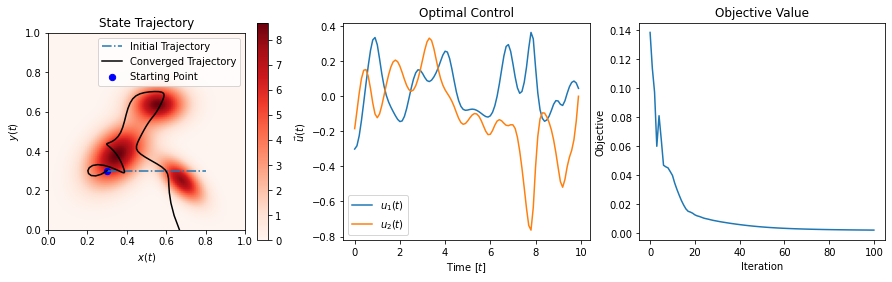

<Figure size 432x288 with 0 Axes>

In [7]:
def dyn_random(_, weights, dists):
    ind_dist = np.random.choice(a=np.arange(len(weights)), size=1, p=weights)[0]
    # print(ind_dist)
    dist = dists[ind_dist]
    return dist.rvs()

w1, w2, w3 = 0.5, 0.2, 0.3

mu1 = np.array([0.35, 0.38])
mu2 = np.array([0.68, 0.25])
mu3 = np.array([0.56, 0.64])

cov1 = np.array([[1e-2, 4e-3], [4e-3, 1e-2]])
cov2 = np.array([[5e-3, -3e-3], [-3e-3, 5e-3]])
cov3 = np.array([[8e-3, 0.0], [0.0, 4e-3]])

T = 10
dt = 0.1
tlist = np.arange(0, T, dt)
tsteps = tlist.shape[0]

u_traj = np.zeros(shape=(100, 2))
x_curr = np.array([0.3, 0.3])

weights = np.array([w1, w2, w3])
means = np.array([mu1, mu2, mu3])
covs = np.array([cov1, cov2, cov3])

# N = N_grid + 1

# dx = dy = 1.0 / N_grid

dists = []
for mu, cov in zip(means, covs):
    dist = scipy.stats.multivariate_normal(mean=mu, cov=cov)
    dists.append(dist)

for i in range(100):
    x_new = dyn_random(None, weights, dists)
    u_traj[i, :] = (x_new - x_curr) / dt
    x_curr = x_new



u_traj = np.tile(np.array([0.05, 0.0]), reps=(tsteps, 1))

main_p1(
            w1=w1,
            w2=w2,
            w3=w3,
            mu1=mu1,
            mu2=mu2,
            mu3=mu3,
            cov1=cov1,
            cov2=cov2,
            cov3=cov3,
            init_u_traj=u_traj,
            q=0.1,
            R_u=np.diag([0.001, 0.001]),
            P1=np.diag([2.0, 2.0]),
            Q_z=np.diag([0.01, 0.001]),
            R_v=np.diag([0.001, 0.001]),
            x0=np.array([0.3, 0.3]),
            # u_traj=u_traj,
            N_grid=100,
            K_per_dim=10,
            dt=0.1,
            T=T,
            max_iter=100,
            gamma_0=0.001,
            fig_filename="problem1.png",
        )

In [1]:
import os
import copy

import numpy as np
import scipy.stats
from scipy.integrate import solve_bvp

import matplotlib.pyplot as plt

phi_list = np.empty(0)
fk_list = np.empty(0)
h_list = np.empty(0)
c_list = np.empty(0)
f_traj = np.empty(0)
lam_list = np.empty(0)
dfkdxdt_list = np.empty(0)

# RESULTS_DIR = os.path.join(os.path.dirname(os.path.abspath(__file__)), "Results")


def pdf(x, weights, dists, dx, dy):
    result = np.zeros(shape=x.shape[0])

    for w, dist in zip(weights, dists):
        result += w * dist.pdf(x)

    result /= np.sum(result * dx * dy)
    return result


def dyn_random(_, weights, dists):
    ind_dist = np.random.choice(a=np.arange(len(weights)), size=1, p=weights)[0]
    # print(ind_dist)
    dist = dists[ind_dist]
    return dist.rvs()


def xdot(_, ut):
    return ut


def next_state(xt, ut, dt):
    k1 = dt * xdot(xt, ut)
    k2 = dt * xdot(xt + k1 / 2.0, ut)
    k3 = dt * xdot(xt + k2 / 2.0, ut)
    k4 = dt * xdot(xt + k3, ut)

    xt_new = xt + 1.0 / 6.0 * (k1 + 2.0 * k2 + 2.0 * k3 + k4)
    return xt_new


# def barr(x_traj):
#     x_traj_barr = np.zeros_like(x_traj)

#     for xt in x_traj:
#         x1, x2 = xt
#         x1_barr = min(0, x-0)**2+max()


def main_p2(
    dt=0.1,
    T=10,
    # init_u_traj=np.zeros(shape=(63, 2)),
    # x0=np.array([0.0, 0.0, np.pi / 2.0]),
    x0=np.array([0.3, 0.3]),
    # Q_x=np.diag([0.01, 0.01, 2.0]),
    q=0.01,
    R_u=np.diag([0.0, 0.0]),
    # P1=np.diag([20.0, 20.0, 5.0]),
    P1=np.diag([2.0, 2.0]),
    # Q_z=np.diag([5.0, 5.0, 1.0]),
    Q_z=np.diag([0.001, 0.001, 0.001]),
    R_v=np.diag([0.01, 0.01, 0.01, 0.01]),
    w1=0.5,
    mu1=np.array([0.35, 0.38]),
    cov1=np.array([[0.01, 0.004], [0.004, 0.01]]),
    w2=0.2,
    mu2=np.array([0.68, 0.25]),
    cov2=np.array([[0.005, -0.003], [-0.003, 0.005]]),
    w3=0.3,
    mu3=np.array([0.56, 0.64]),
    cov3=np.array([[0.008, 0.0], [0.0, 0.004]]),
    init_u_traj=np.tile(np.array([-0.1, 0.1]), reps=100),
    N_grid=1000,
    K_per_dim=10,
    gamma_0=0.001,
    max_iter=100,
    fig_filename="example.png",
    mul = 1
):
    tlist = np.arange(0, T, dt)
    tsteps = tlist.shape[0]

    weights = np.array([w1, w2, w3])
    means = np.array([mu1, mu2, mu3])
    covs = np.array([cov1, cov2, cov3])

    N = N_grid + 1

    dx = dy = 1.0 / N_grid

    dists = []
    for mu, cov in zip(means, covs):
        dist = scipy.stats.multivariate_normal(mean=mu, cov=cov)
        dists.append(dist)

    kdim_x = np.arange(K_per_dim)
    kdim_y = np.arange(K_per_dim)

    ks_x, ks_y = np.meshgrid(kdim_x, kdim_y)
    ks_xy = np.array([ks_x.ravel(), ks_y.ravel()]).T

    L_list = np.array([1, 1], dtype="float")

    grid_x, grid_y = np.meshgrid(
        np.linspace(0, L_list[0], N),
        np.linspace(0, L_list[1], N),
    )
    grids_xy = np.array([grid_x.ravel(), grid_y.ravel()]).T
    pdf_gt = pdf(
        x=grids_xy,
        weights=weights,
        dists=dists,
        dx=dx,
        dy=dy,
    )

    phi_list = np.zeros(ks_xy.shape[0])
    fk_list = np.zeros(shape=(ks_xy.shape[0], N**2))
    h_list = np.zeros(ks_xy.shape[0])

    for i, k_vec in enumerate(ks_xy):
        fk_vals = np.prod(np.cos(k_vec * np.pi / L_list * grids_xy), axis=1)
        hk = np.sqrt(np.sum(np.square(fk_vals)) * dx * dy)
        fk_vals /= hk
        phi_k = np.sum(pdf_gt * fk_vals * dx * dy)

        h_list[i] = hk
        fk_list[i, :] = fk_vals
        phi_list[i] = phi_k

    c_list = np.zeros(ks_xy.shape[0])
    f_traj = np.zeros((ks_xy.shape[0], tsteps))
    lam_list = np.power(1.0 + np.linalg.norm(ks_xy, axis=1), -3.0 / 2.0)
    dfkdxdt_list = np.zeros((ks_xy.shape[0], 2))
    def dyn(xt, ut):
        # xdot = np.zeros(3)  # replace this
        # theta = xt[2]
        # u1 = ut[0]
        # u2 = ut[1]
        # x1dot = np.cos(theta) * u1
        # x2dot = np.sin(theta) * u1
        # x3dot = u2
        x1dot = xt[2]
        x2dot = xt[3]
        x1ddot = ut[0]
        x2ddot = ut[1]

        # xdot = np.array([x1dot, x2dot, x3dot])
        # xdot = copy.deepcopy(ut)
        xdot = np.array([x1dot, x2dot, x1ddot, x2ddot])
        return xdot

    def get_A(t, xt, ut):
        # theta = xt[2]
        # u1 = ut[0]
        # A_mat = np.zeros((2, 2))  # replace this
        A_mat = np.zeros((4, 4))
        A_mat[0, 2] = 1
        A_mat[1, 3] = 1
        # A_mat[0, 2] = -np.sin(theta) * u1
        # A_mat[1, 2] = np.cos(theta) * u1
        return A_mat

    def get_B(t, xt, ut):
        # theta = xt[2]
        B_mat = np.zeros((4, 2))  # replace this
        B_mat[2, 0] = 1
        B_mat[3, 1] = 1
        # B_mat = np.eye(2)
        # B_mat[0, 0] = np.cos(theta)
        # B_mat[1, 0] = np.sin(theta)
        # B_mat[2, 1] = 1
        return B_mat
    def get_xd(t):
        xd = np.array([2.0 * t / np.pi, 0.0, np.pi / 2.0])
        return xd

    def step(xt, ut):
        # xt_new = xt + dt * dyn(xt, ut)  # recommended: replace it with RK4 integration
        k1 = dt * dyn(xt, ut)
        k2 = dt * dyn(xt + k1 / 2.0, ut)
        k3 = dt * dyn(xt + k2 / 2.0, ut)
        k4 = dt * dyn(xt + k3, ut)

        xt_new = xt + 1.0 / 6.0 * (k1 + 2.0 * k2 + 2.0 * k3 + k4)
        return xt_new

    def traj_sim(x0, ulist):
        # tsteps = ulist.shape[0]
        x_traj = np.zeros((tsteps + 1, x0.shape[0]))
        x_traj[0, :] = x0
        xt = copy.deepcopy(x0)
        for t in range(tsteps):
            xt_new = step(xt, ulist[t])
            x_traj[t + 1] = copy.deepcopy(xt_new)
            xt = copy.deepcopy(xt_new)
        return x_traj

    # def loss(t, xt, ut):
    #     # xd = np.array([2.0 * t / np.pi, 0.0, np.pi / 2.0])  # desired system state at time t
    #     xd = get_xd(t)

    #     x_diff = xt - xd
    #     # x_loss = 0.0  # replace this
    #     x_loss = x_diff.T @ Q_x @ x_diff
    #     # u_loss = 0.0  # replace this
    #     u_loss = ut.T @ R_u @ ut

    #     return x_loss + u_loss

    def dldx(t, xt, ut):
        # xd = np.array([2.0 * t / np.pi, 0.0, np.pi / 2.0])
        # xd = get_xd(t)
        # qlist = np.diag(Q_x)
        t_ind = np.where(tlist == t)[0][0]
        dvec = np.zeros(2)  # replace this
        for lam_k, ck, phi_k, hk, k_vec, fk_traj, dfkdxdt in zip(
            lam_list, c_list, phi_list, h_list, ks_xy, f_traj, dfkdxdt_list
        ):
            # ax_val
            # k1, k2 = k_vec
            # d_fk = np.zeros(2)
            # for xt in x_traj:
            fk_t = fk_traj[t_ind]
            # dfkdxdt = dfkdxdt_list
            # print(dfkdxdt)
            dfkdx = (
                -1.0
                / hk
                * (
                    k_vec
                    * np.pi
                    * np.sin(k_vec * np.pi * xt)
                    * np.cos(k_vec[::-1] * np.pi * xt[::-1])
                )
            )

            # dvec += lam_k / (T**2) * (dfkdx * ck * T - 2 * T * dfkdx * phi_k)
            # dvec += lam_k / (T**2) * (fk_t * dfkdxdt)
            dvec += q * lam_k * (2 * (ck - phi_k) * 1 / T * dfkdx)

        # dx = xt - xd
        # dvec = 2 * qlist * dx
        return dvec

    def dldu(t, xt, ut):
        dvec = np.zeros(2)  # replace this
        rlist = np.diag(R_u)
        dvec = rlist * ut
        return dvec

    def func_J(x_traj, u_traj):
        J_val = 0

        # print(c_list)
        J_val += q * np.sum(lam_list * np.square(c_list - phi_list))
        # print(u_traj.T @ R_u @ u_traj)
        for ut in u_traj:
            # print(ut)
            J_val += ut.T @ R_u @ ut * dt
        # for xt, ut, t in zip(x_traj[:, :], u_traj, tlist):
        #     l_val = loss(t, xt, ut)
        #     J_val += l_val

        # xd_T = get_xd(tlist[-1])
        # xT = x_traj[-1]
        # dx_T = xT - xd_T

        # J_val += dx_T.T @ P1 @ dx_T

        return J_val

    def ilqr_iter(x0, u_traj):
        """
        :param x0: initial state of the system
        :param u_traj: current estimation of the optimal control trajectory
        :return: the descent direction for the control
        """
        # forward simulate the state trajectory
        x_traj = traj_sim(x0, u_traj)

        c_list = np.zeros(ks_xy.shape[0])
        f_traj = np.zeros([ks_xy.shape[0], x_traj.shape[0]])
        for i, (k_vec, hk) in enumerate(zip(ks_xy, h_list)):
            fk_vals = np.prod(np.cos(k_vec * np.pi / L_list * x_traj), axis=1)
            dfkdxdt = np.zeros(2)

            hk = h_list[i]
            fk_vals /= hk

            ck = np.sum(fk_vals) * dt / T

            for xt in x_traj:
                dfkdx = (
                    -1
                    / hk
                    * k_vec
                    * np.sin(k_vec * np.pi * xt)
                    * np.cos(k_vec[::-1] * np.pi * xt[::-1])
                )
                dfkdxdt += dfkdx * dt

            # print(fk_vals.shape)
            # fk_vals_gt = fk_list[i, :]

            dfkdxdt_list[i, :] = copy.deepcopy(dfkdxdt)
            f_traj[i, :] = fk_vals
            c_list[i] = ck

        # print("in loop: ", c_list)
        # print(dfkdxdt_list)

        # compute other variables needed for specifying the dynamics of z(t) and p(t)
        A_list = np.zeros((tsteps, 2, 2))
        B_list = np.zeros((tsteps, 2, 2))
        a_list = np.zeros((tsteps, 2))
        b_list = np.zeros((tsteps, 2))
        for t_idx, t in np.ndenumerate(tlist):
            # t = t_idx * dt
            A_list[t_idx] = get_A(t, x_traj[t_idx], u_traj[t_idx])
            B_list[t_idx] = get_B(t, x_traj[t_idx], u_traj[t_idx])
            a_list[t_idx] = dldx(t, x_traj[t_idx], u_traj[t_idx])
            b_list[t_idx] = dldu(t, x_traj[t_idx], u_traj[t_idx])

        xd_T = get_xd(tlist[-1])  # desired terminal state
        xT = x_traj[-1, :]
        xT_2 = x_traj[int(x_traj.shape[0] / 2), :]

        plist = np.diag(P1)
        # p1 = np.zeros(3)  # replace it to be the terminal condition p(T)

        p1 = 2 * plist * (xT - mu2) * (xT_2 - mu3)
        # p1 = plist * xT
        p1 = np.zeros(2)

        def zp_dyn(t, zp):
            zt = zp[:2]
            pt = zp[2:]

            t_idx = int(t / dt)
            At = A_list[t_idx]
            Bt = B_list[t_idx]
            at = a_list[t_idx]
            bt = b_list[t_idx]

            # M_11 = np.zeros((3,3))  # replace this
            M_11 = At
            M_12 = np.zeros((2, 2))  # replace this
            M_21 = np.zeros((2, 2))  # replace this
            # M_22 = np.zeros((3,3))  # replace this
            M_22 = -At.T
            dyn_mat = np.block([[M_11, M_12], [M_21, M_22]])

            # m_1 = np.zeros(3)  # replace this
            m_1 = -Bt @ np.linalg.inv(R_v.T) @ (pt.T @ Bt + bt.T)
            # m_2 = np.zeros(3)  # replace this
            m_2 = -at - zt @ Q_z
            dyn_vec = np.hstack([m_1, m_2])

            return dyn_mat @ zp + dyn_vec

        # this will be the actual dynamics function you provide to solve_bvp,
        # it takes in a list of time steps and corresponding [z(t), p(t)]
        # and returns a list of [zdot(t), pdot(t)]
        def zp_dyn_list(t_list, zp_list):
            list_len = len(t_list)
            zp_dot_list = np.zeros((4, list_len))
            for _i in range(list_len):
                zp_dot_list[:, _i] = zp_dyn(t_list[_i], zp_list[:, _i])
            return zp_dot_list

        # boundary condition (inputs are [z(0),p(0)] and [z(T),p(T)])
        def zp_bc(zp_0, zp_T):
            # return np.zeros(6)  # replace this
            z0 = zp_0[:2]
            p0 = zp_0[2:]

            zT = zp_T[:2]
            pT = zp_T[2:]

            bc = np.zeros(4)
            bc[:2] = z0
            bc[2:] = np.abs(pT - p1)
            # print(bc)

            return bc

        ### The solver will say it does not converge, but the returned result
        ### is numerically accurate enough for our use
        # zp_traj = np.zeros((tsteps,6))  # replace this by using solve_bvp
        res = solve_bvp(
            zp_dyn_list,
            zp_bc,
            tlist,
            np.zeros(shape=(4, tsteps)),
            verbose=1,
            max_nodes=100,
        )
        # zp_traj = np.zeros(shape=(tsteps, 6))
        # # print(res.x.shape)

        # for i in range(6):
        #     f = sitr.interp1d(res.x, res.y.T[:, i])
        #     zp_traj[:, i] = f(tlist)
        zp_traj = res.sol(tlist).T

        # print(zp_traj)

        z_traj = zp_traj[:, :2]
        p_traj = zp_traj[:, 2:]

        v_traj = np.zeros((tsteps, 2))
        for _i in range(tsteps):
            At = A_list[_i]
            Bt = B_list[_i]
            at = a_list[_i]
            bt = b_list[_i]

            zt = z_traj[_i]
            pt = p_traj[_i]

            # vt = np.zeros(2)  # replace this
            vt = -np.linalg.inv(R_v.T) @ (pt.T @ Bt + bt.T)
            v_traj[_i, :] = vt

        return v_traj, c_list

    # Start iLQR iterations here

    u_traj = init_u_traj.copy()
    Jlist = np.array([func_J(traj_sim(x0, u_traj), u_traj)])

    for iter in range(max_iter):
        print(f"Iteration {iter} ...")
        # forward simulate the current trajectory
        x_traj = traj_sim(x0, u_traj)

        # visualize the current trajectory
        # fig, axs = plt.subplots(1, 2)
        # axs[0].set_title(f"Iter: {iter}")
        # axs[0].set_aspect("equal")
        # axs[0].set_xlim(-0.2, 4.2)
        # axs[0].set_ylim(-0.2, 2.2)
        # axs[0].plot(x_traj[:, 0], x_traj[:, 1], linestyle="-", color="C0")

        # axs[1].plot(tlist, u_traj[:, 0], linestyle="-", label="u_1")
        # axs[1].plot(tlist, u_traj[:, 1], linestyle="-", label="u_2")
        # axs[1].legend()
        # plt.show()
        # plt.close()

        # get descent direction

        # print("before: ", c_list)
        v_traj, c_list = ilqr_iter(x0, u_traj)
        # print("after: ", c_list)
        # print(v_traj)

        # Armijo line search parameters
        gamma = copy.deepcopy(gamma_0)  # initial step size
        alpha = 1e-4
        beta = 0.5

        # print(-v_traj.T @ v_traj)

        ### Implement Armijo line search here to update step size gamma
        while func_J(x_traj, u_traj + gamma * v_traj) > func_J(
            x_traj, u_traj
        ) + alpha * gamma * np.abs(np.trace(-v_traj.T @ v_traj)):
            gamma *= beta

        # gamma = 0

        # update control for the next iteration
        u_traj += gamma * v_traj
        Jlist = np.hstack([Jlist, func_J(x_traj, u_traj)])
        print(f"Gamma = {gamma}, J = {Jlist[-1]}")
        # if gamma < 1e-5:
        #     break

    # print(Jlist)
    init_x_traj = traj_sim(x0, init_u_traj)
    # xd_traj = np.zeros(shape=(tsteps, x0.shape[0]))

    # for i in range(tsteps):
    #     xd_traj[i, :] = get_xd(tlist[i])

    # print(x_traj.shape, u_traj.shape)
    # print(xd_traj)

    fig, axs = plt.subplots(1, 3, figsize=(15, 4))

    axs[0].set_title("State Trajectory")
    axs[0].set_xlabel(r"$x(t)$")
    axs[0].set_ylabel(r"$y(t)$")
    cax = axs[0].imshow(
        pdf_gt.reshape(N, N),
        origin="lower",
        cmap="Reds",
        extent=[0, 1, 0, 1],
    )
    axs[0].plot(
        init_x_traj[:, 0],
        init_x_traj[:, 1],
        linestyle="-.",
        label="Initial Trajectory",
    )
    axs[0].plot(
        x_traj[:, 0],
        x_traj[:, 1],
        linestyle="-",
        color="k",
        label="Converged Trajectory",
    )
    axs[0].scatter(x0[0], x0[1], color="b", s=40, label="Starting Point")
    fig.colorbar(cax, ax=axs[0])
    # axs[0].plot(
    #     xd_traj[:, 0],
    #     xd_traj[:, 1],
    #     linestyle="--",
    #     label="Desired Trajectory",
    # )
    # axs[0].set_aspect("equal")
    axs[0].set_xlim(0, 1)
    axs[0].set_ylim(0, 1)
    axs[0].legend()

    axs[1].set_title("Optimal Control")
    axs[1].set_xlabel(r"Time $[t]$")
    axs[1].set_ylabel(r"$\vec{u}(t)$")
    axs[1].plot(tlist, u_traj[:, 0], label=r"$u_1(t)$")
    axs[1].plot(tlist, u_traj[:, 1], label=r"$u_2(t)$")
    axs[1].legend()

    axs[2].set_title("Objective Value")
    axs[2].set_xlabel("Iteration")
    axs[2].set_ylabel("Objective")
    axs[2].plot(Jlist)
    plt.show()
    plt.savefig(fname=os.path.join(fig_filename), format="png", dpi=300)
    # plt.close()

In [4]:
main_p2(
            w1=w1,
            w2=w2,
            w3=w3,
            mu1=mu1,
            mu2=mu2,
            mu3=mu3,
            cov1=cov1,
            cov2=cov2,
            cov3=cov3,
            init_u_traj=u_traj,
            q=0.1,
            R_u=np.diag([0.01, 0.01]),
            P1=np.diag([2.0, 2.0]),
            Q_z=np.diag([0.01, 0.01, 0.001, 0.001]),
            R_v=np.diag([0.01, 0.01]),
            x0=np.array([0.3, 0.3, 0.0, 0.0]),
            # u_traj=u_traj,
            N_grid=100,
            K_per_dim=10,
            dt=0.1,
            T=T,
            max_iter=100,
            gamma_0=0.001,
            fig_filename="problem2.png",
            mul=1,
        )

Iteration 0 ...


ValueError: operands could not be broadcast together with shapes (2,) (101,4) 